# What-if scenarios

In this stage of the analysis, we want to find how changes to the parameters of our model affect the simulated data.

Some areas of interest are:

- How would server utilisation (i.e. resource consumption) be affected by an increase in overall patient arrivals?
- How is the system affected by certain types of patients (e.g. short-stay, low-impact) arriving less frequently?
- What are the sensitivities of mean system times and server utilisation based on a change in $c$?

In [1]:
import glob
import itertools as it
import time

from ciw.dists import Exponential
from dask.diagnostics import ProgressBar
from scipy import stats

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")

In [2]:
copd = pd.read_csv(
    "../data/clusters/copd_clustered.csv",
    parse_dates=["admission_date", "discharge_date"],
).dropna(subset=["cluster"])

copd["cluster"] = copd["cluster"].astype(int)
n_clusters = copd["cluster"].nunique()

In [3]:
with open("../data/wasserstein/best/params.txt", "r") as f:
    strings = f.read().split(" ")
    props, num_servers = list(map(float, strings[:-2])), int(strings[-2])

props, num_servers

([0.95, 1.0, 1.0, 0.5], 40)

## Change in overall patient arrivals

In [4]:
sigma_utilisations = pd.read_csv("../data/lambda_scaling/utilisations.csv")

original_median_utilisation = sigma_utilisations[np.isclose(sigma_utilisations["sigma"], 1)][
    "utilisation"
].median()

sigma_utilisations["relative_utilisation"] = (
    sigma_utilisations["utilisation"] / original_median_utilisation
)

In [5]:
sigma_uniques = sigma_utilisations["sigma"].unique()

sigma_min = f"{min(sigma_uniques):.1f}%"
sigma_max = f"{max(sigma_uniques):.1f}%"
sigma_step = f"{(sigma_uniques[1] - sigma_uniques[0]):.1e}"

with open("../tex/lambda_scaling_min.tex", "w") as f:
    f.write(sigma_min)

with open("../tex/lambda_scaling_max.tex", "w") as f:
    f.write(sigma_max)

with open("../tex/lambda_scaling_step.tex", "w") as f:
    coeff, power = sigma_step.split("e")
    start, end = "\\(", "}\\)%"
    power = power[0] + power[-1]
    string = start + coeff + " \\times 10^{" + power + end
    f.write(string)

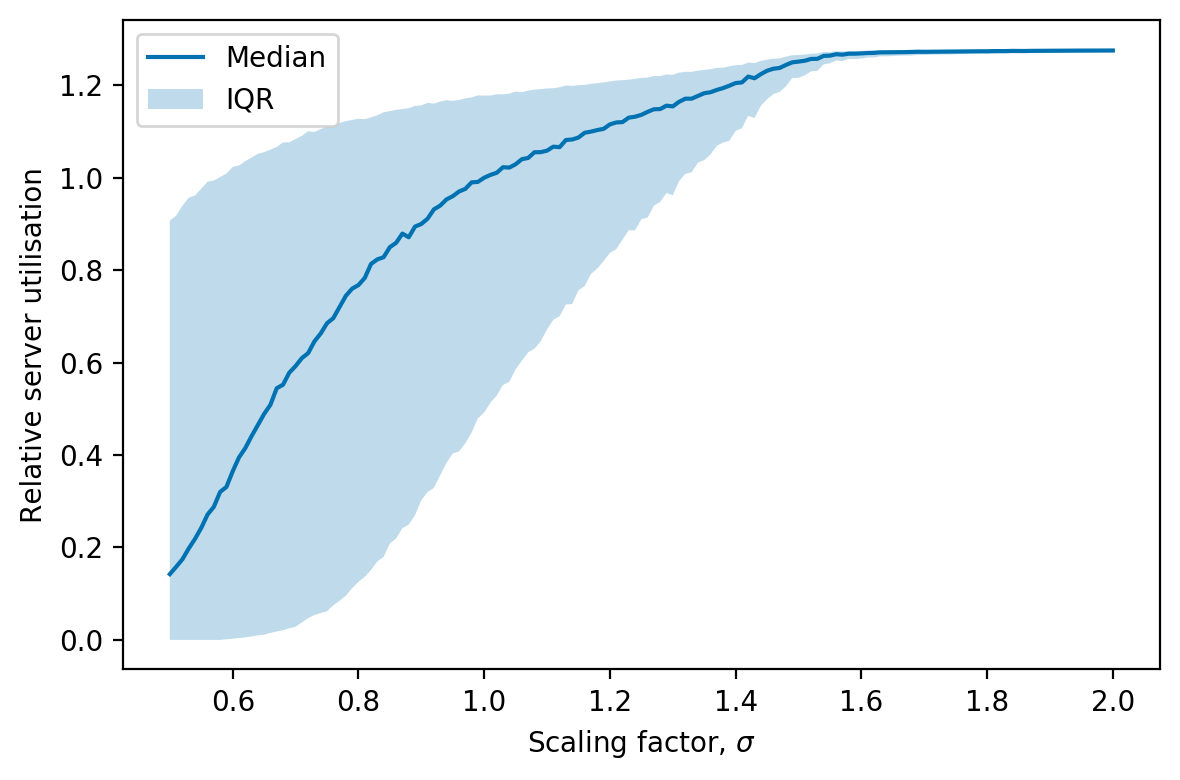

In [6]:
fig, ax = plt.subplots(dpi=200)

groupby = sigma_utilisations.groupby("sigma")["relative_utilisation"]

median = groupby.median()
lower, upper = groupby.quantile(0.25), groupby.quantile(0.75)

ax.plot(median, label="Median")
ax.fill_between(lower.index, lower, upper, alpha=0.25, label="IQR")

ax.set(
    xlabel="Scaling factor, $\sigma$", ylabel="Relative server utilisation"
)

ax.legend()

plt.tight_layout()
plt.savefig("../img/lambda_util.pdf", transparent=True)

In [7]:
sigma_system_times = pd.read_csv("../data/lambda_scaling/system_times.csv")

original_median_system_time = sigma_system_times[np.isclose(sigma_system_times["sigma"], 1)][
    "system_time"
].median()

sigma_system_times["relative_system_time"] = (
    sigma_system_times["system_time"] / original_median_system_time
)

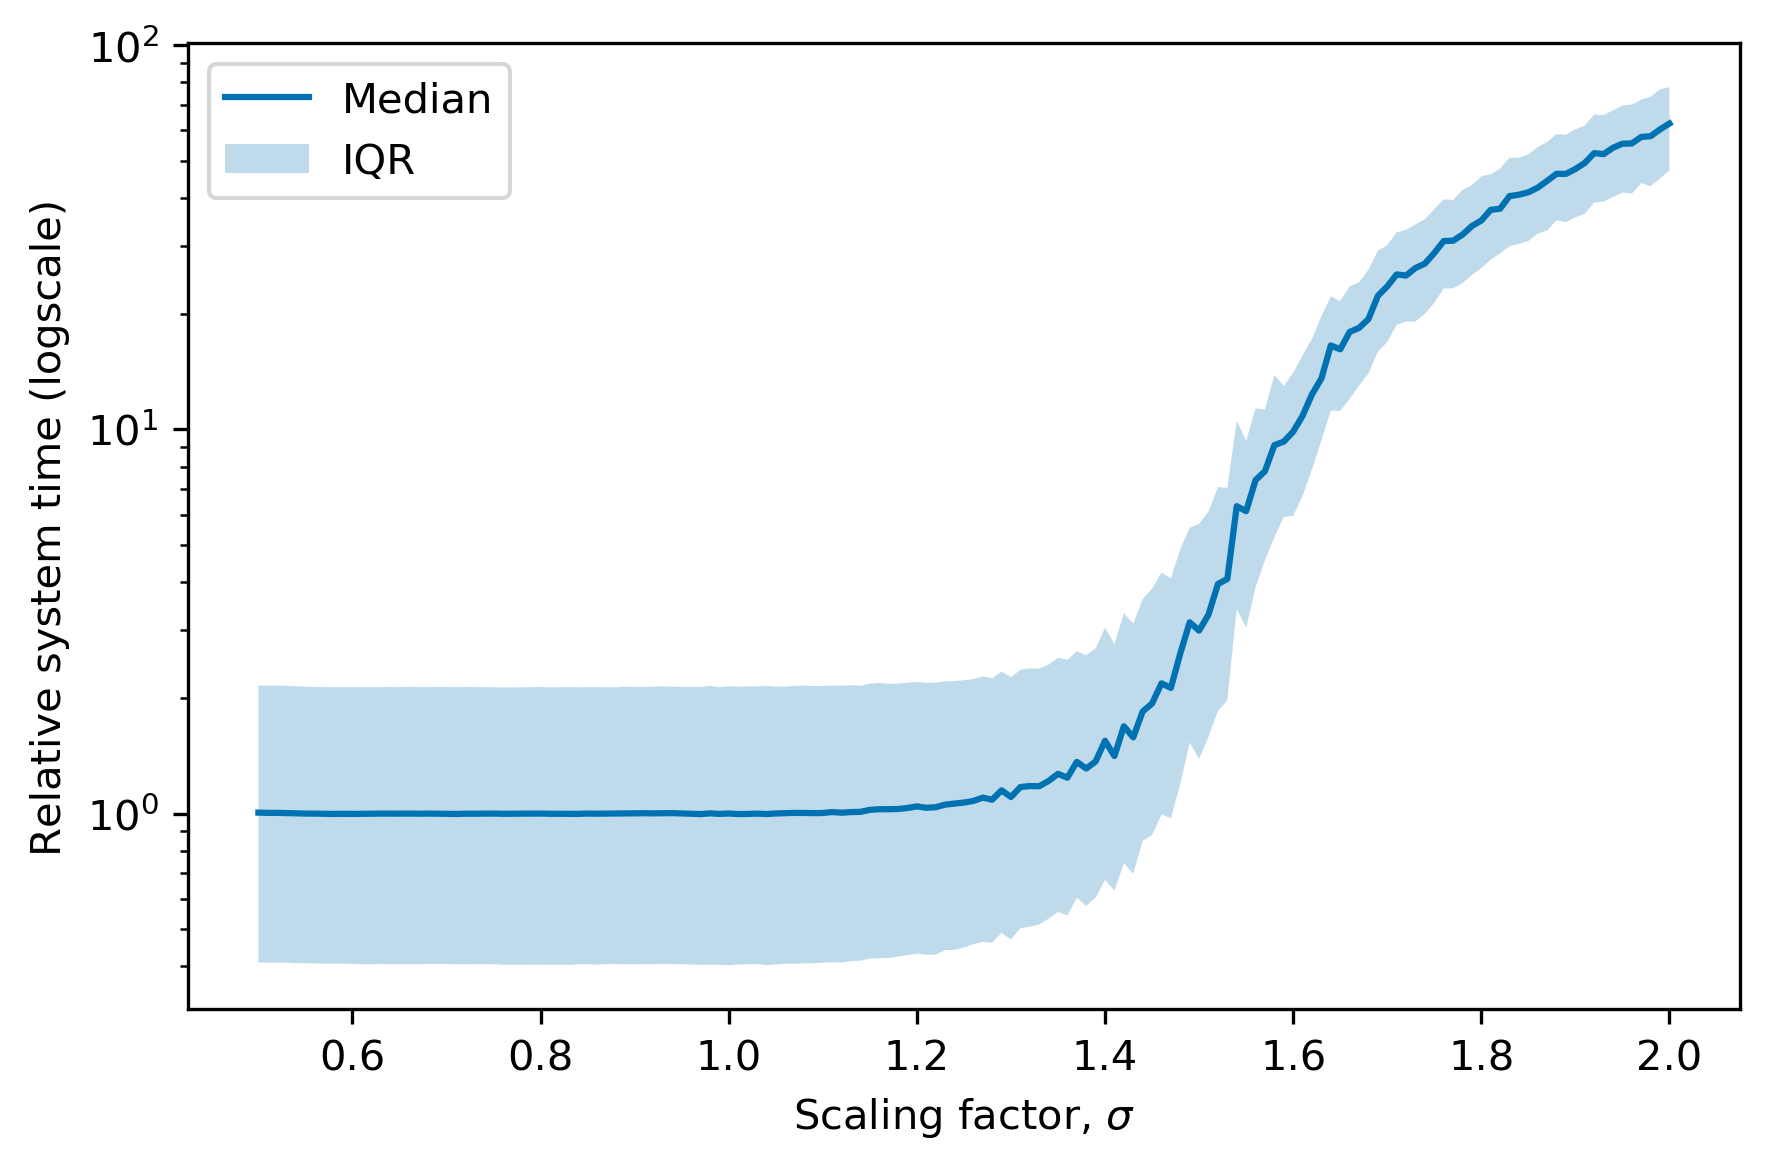

In [8]:
fig, ax = plt.subplots(dpi=300)

groupby = sigma_system_times.groupby("sigma")["relative_system_time"]

median = groupby.median()
lower = groupby.quantile(0.25)
upper = groupby.quantile(0.75)

ax.plot(median, label="Median")
ax.fill_between(lower.index, lower, upper, alpha=0.25, label="IQR")

ax.set(
    xlabel="Scaling factor, $\sigma$", ylabel="Relative system time (logscale)", yscale="log"
)

ax.legend()

plt.tight_layout()
plt.savefig("../img/lambda_time.pdf", transparent=True)

## Sensitivity analysis for $c$

In [9]:
servers_utilisations = pd.read_csv("../data/num_servers_change/utilisations.csv")
servers_utilisations["relative_num_servers"] = servers_utilisations["num_servers"] / num_servers

original_median_utilisation = servers_utilisations[servers_utilisations["relative_num_servers"] == 1][
    "utilisation"
].median()

servers_utilisations["relative_utilisation"] = (
    servers_utilisations["utilisation"] / original_median_utilisation
)

In [10]:
servers_uniques = servers_utilisations["relative_num_servers"].unique()

servers_min = f"{min(servers_uniques):.1f}%"
servers_max = f"{max(servers_uniques):.1f}%"
servers_step = f"{(servers_uniques[1] - servers_uniques[0]):.1e}"

with open("../tex/num_servers_change_min.tex", "w") as f:
    f.write(servers_min)

with open("../tex/num_servers_change_max.tex", "w") as f:
    f.write(servers_max)

with open("../tex/num_servers_change_step.tex", "w") as f:
    coeff, power = servers_step.split("e")
    start, end = "\\(", "}\\)%"
    power = power[0] + power[-1]
    string = start + coeff + " \\times 10^{" + power + end
    f.write(string)

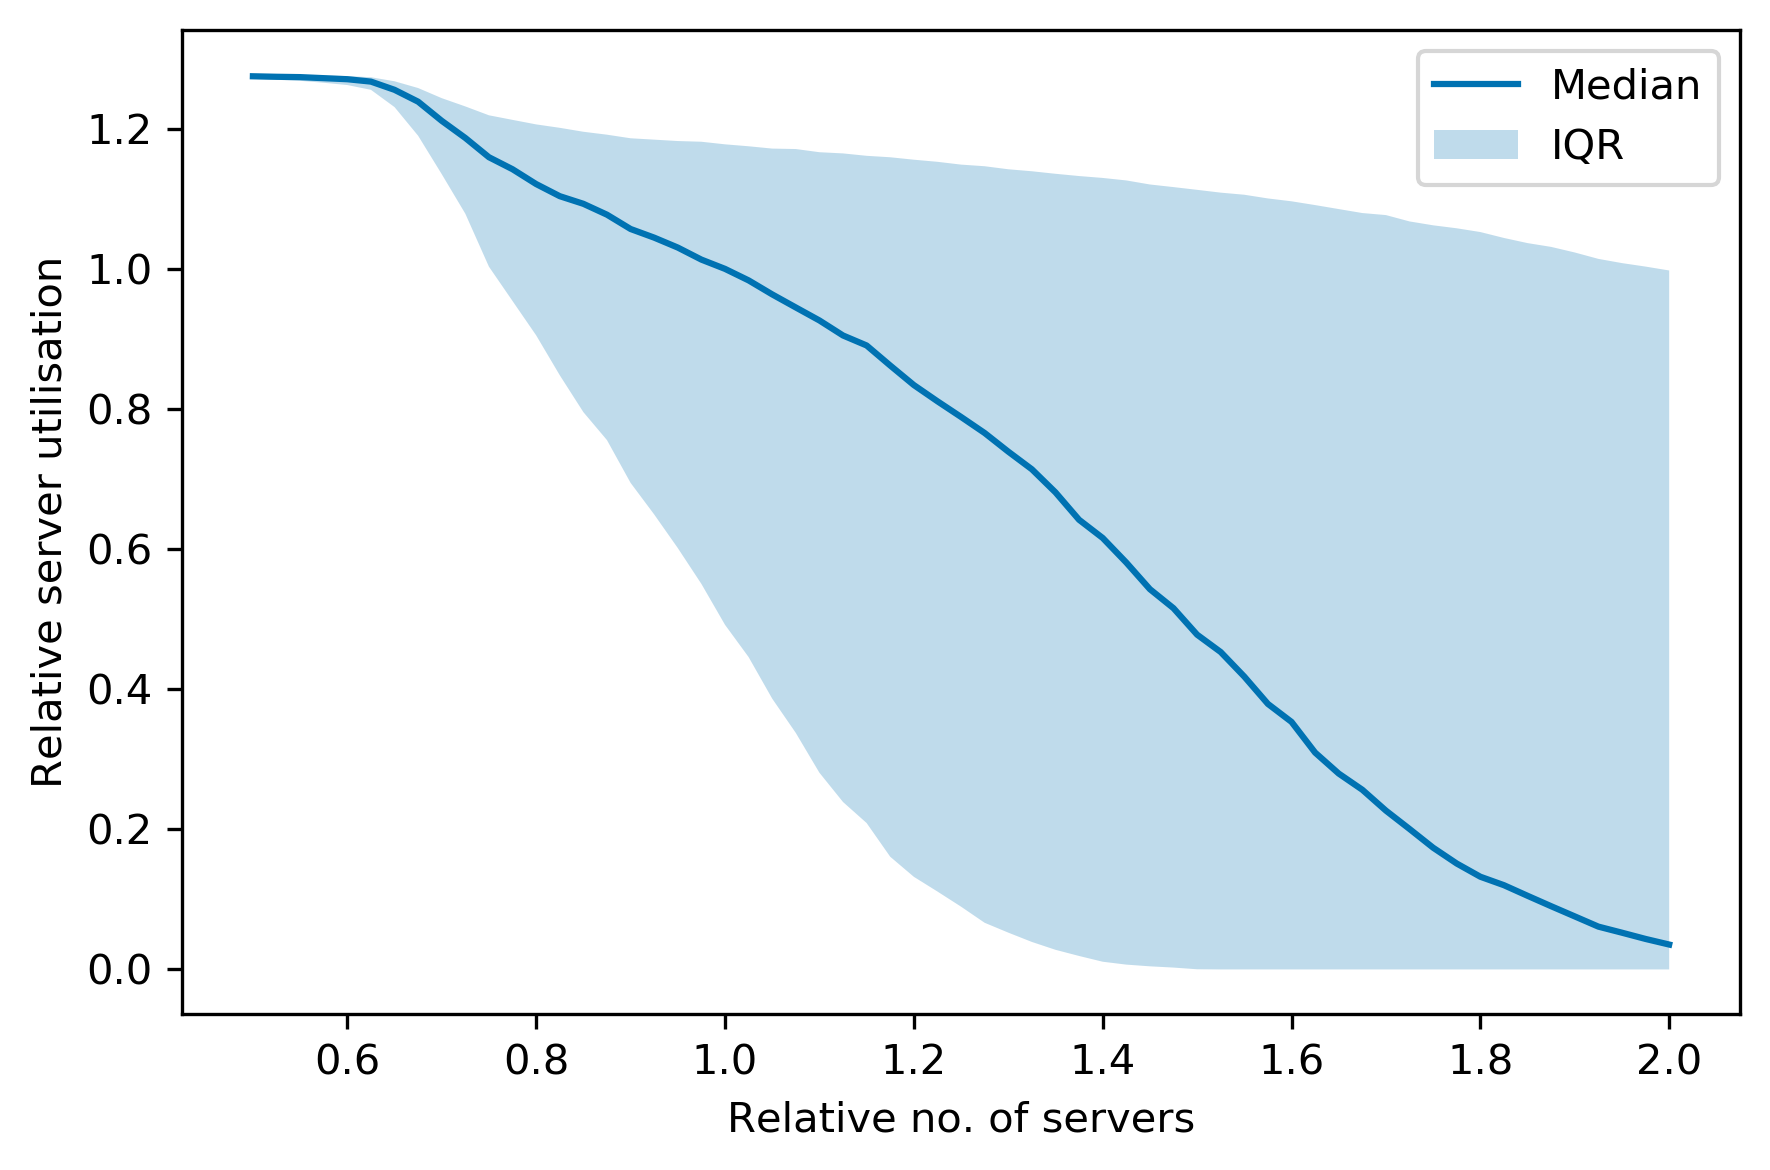

In [11]:
fig, ax = plt.subplots(dpi=300)

groupby = servers_utilisations.groupby("relative_num_servers")["relative_utilisation"]

median = groupby.median()
lower, upper = groupby.quantile(0.25), groupby.quantile(0.75)

ax.plot(median, label="Median")
ax.fill_between(lower.index, lower, upper, alpha=0.25, label="IQR")

ax.set(
    xlabel="Relative no. of servers", ylabel="Relative server utilisation"
)

ax.legend()

plt.tight_layout()
plt.savefig("../img/servers_util.pdf", transparent=True)

In [12]:
servers_system_times = pd.read_csv("../data/num_servers_change/system_times.csv")
servers_system_times["relative_num_servers"] = servers_system_times["num_servers"] / num_servers

original_median_system_time = servers_system_times[np.isclose(servers_system_times["relative_num_servers"], 1)][
    "system_time"
].median()

servers_system_times["relative_system_time"] = (
    servers_system_times["system_time"] / original_median_system_time
)

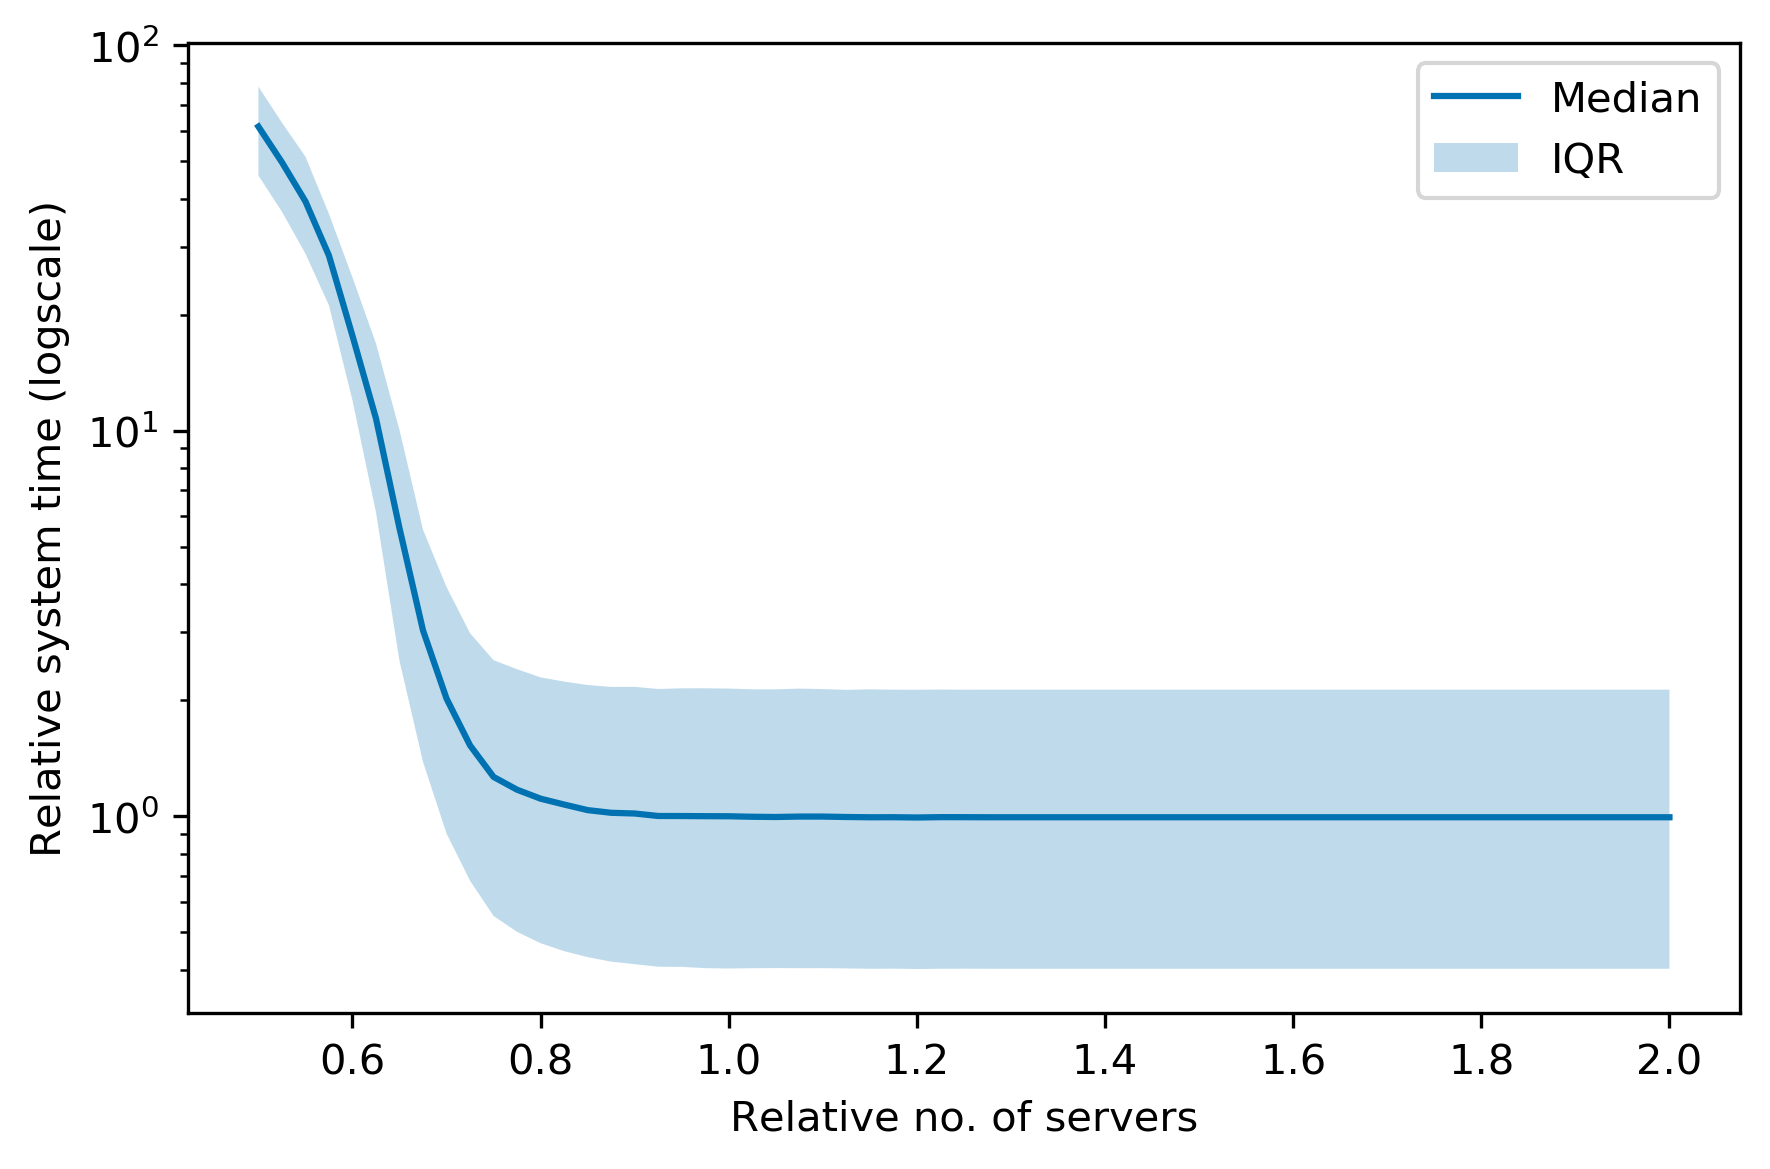

In [13]:
fig, ax = plt.subplots(dpi=300)

groupby = servers_system_times.groupby("relative_num_servers")["relative_system_time"]

median = groupby.median()
lower, upper = groupby.quantile(0.25), groupby.quantile(0.75)

ax.plot(median, label="Median")
ax.fill_between(lower.index, lower, upper, alpha=0.25, label="IQR")

ax.set(
    xlabel="Relative no. of servers", ylabel="Relative system time (logscale)", yscale="log"
)

ax.legend()

plt.tight_layout()
plt.savefig("../img/servers_time.pdf", transparent=True)

## Transferring patients between clusters

In [14]:
moving_utilisations = pd.read_csv("../data/moving_clusters/utilisations.csv")
moving_system_times = pd.read_csv("../data/moving_clusters/system_times.csv")

In [15]:
moving_uniques = moving_utilisations["prop_to_move"].unique()

moving_min = f"{min(moving_uniques):.1f}%"
moving_max = f"{max(moving_uniques) + moving_uniques[1] - moving_uniques[0]:.1f}%"
moving_step = f"{(moving_uniques[1] - moving_uniques[0]):.1e}"

with open("../tex/moving_clusters_min.tex", "w") as f:
    f.write(moving_min)

with open("../tex/moving_clusters_max.tex", "w") as f:
    f.write(moving_max)

with open("../tex/moving_clusters_step.tex", "w") as f:
    coeff, power = moving_step.split("e")
    start, end = "\\(", "}\\)%"
    power = power[0] + power[-1]
    string = start + coeff + " \\times 10^{" + power + end
    f.write(string)

In [16]:
def get_plotting_data(data, column):

    data = data.copy()
    original_median = data[data["prop_to_move"] == 0][column].median()
    data[f"relative_{column}"] = data[column] / original_median

    values = data.groupby("prop_to_move")[f"relative_{column}"]

    lower = values.quantile(0.25)
    median = values.median()
    upper = values.quantile(0.75)

    return lower, median, upper


def make_split_plot(data, column, ylabel_text, path=None, yscale="linear", size=5, yticks=None):

    fig, axes = plt.subplots(
        nrows=n_clusters,
        ncols=n_clusters,
        sharex=True,
        sharey=True,
        figsize=(size, size),
        dpi=300,
    )

    left, width = 0.25, 0.5
    bottom, height = 0.25, 0.5
    right = left + width
    top = bottom + height

    ylabel = fig.text(
        0,
        0.5 * (bottom + top),
        ylabel_text,
        ha="right",
        va="center",
        rotation="vertical",
    )

    xlabel = fig.text(
        0.5 * (left + right),
        -0.01,
        "Transfer proportion, $\delta$",
        ha="center",
        va="bottom",
        rotation="horizontal",
    )

    for origin, destination in it.product(range(n_clusters), repeat=2):

        ax = axes[origin, destination]
        ax.set_yscale(yscale)
        if yticks is not None:
            ax.set_yticks(yticks)

        if origin != destination:
            subdata = data[
                (data["origin"] == origin)
                & (data["destination"] == destination)
            ]

            lower, median, upper = get_plotting_data(subdata, column)

            ax.plot(median)
            ax.fill_between(lower.index, lower, upper, alpha=0.25)
            ax.set_title(f"{origin} to {destination}")

    plt.tight_layout()
    if path is not None:
        plt.savefig(
            path,
            bbox_extra_artists=(xlabel, ylabel),
            bbox_inches="tight",
            transparent=True,
        )

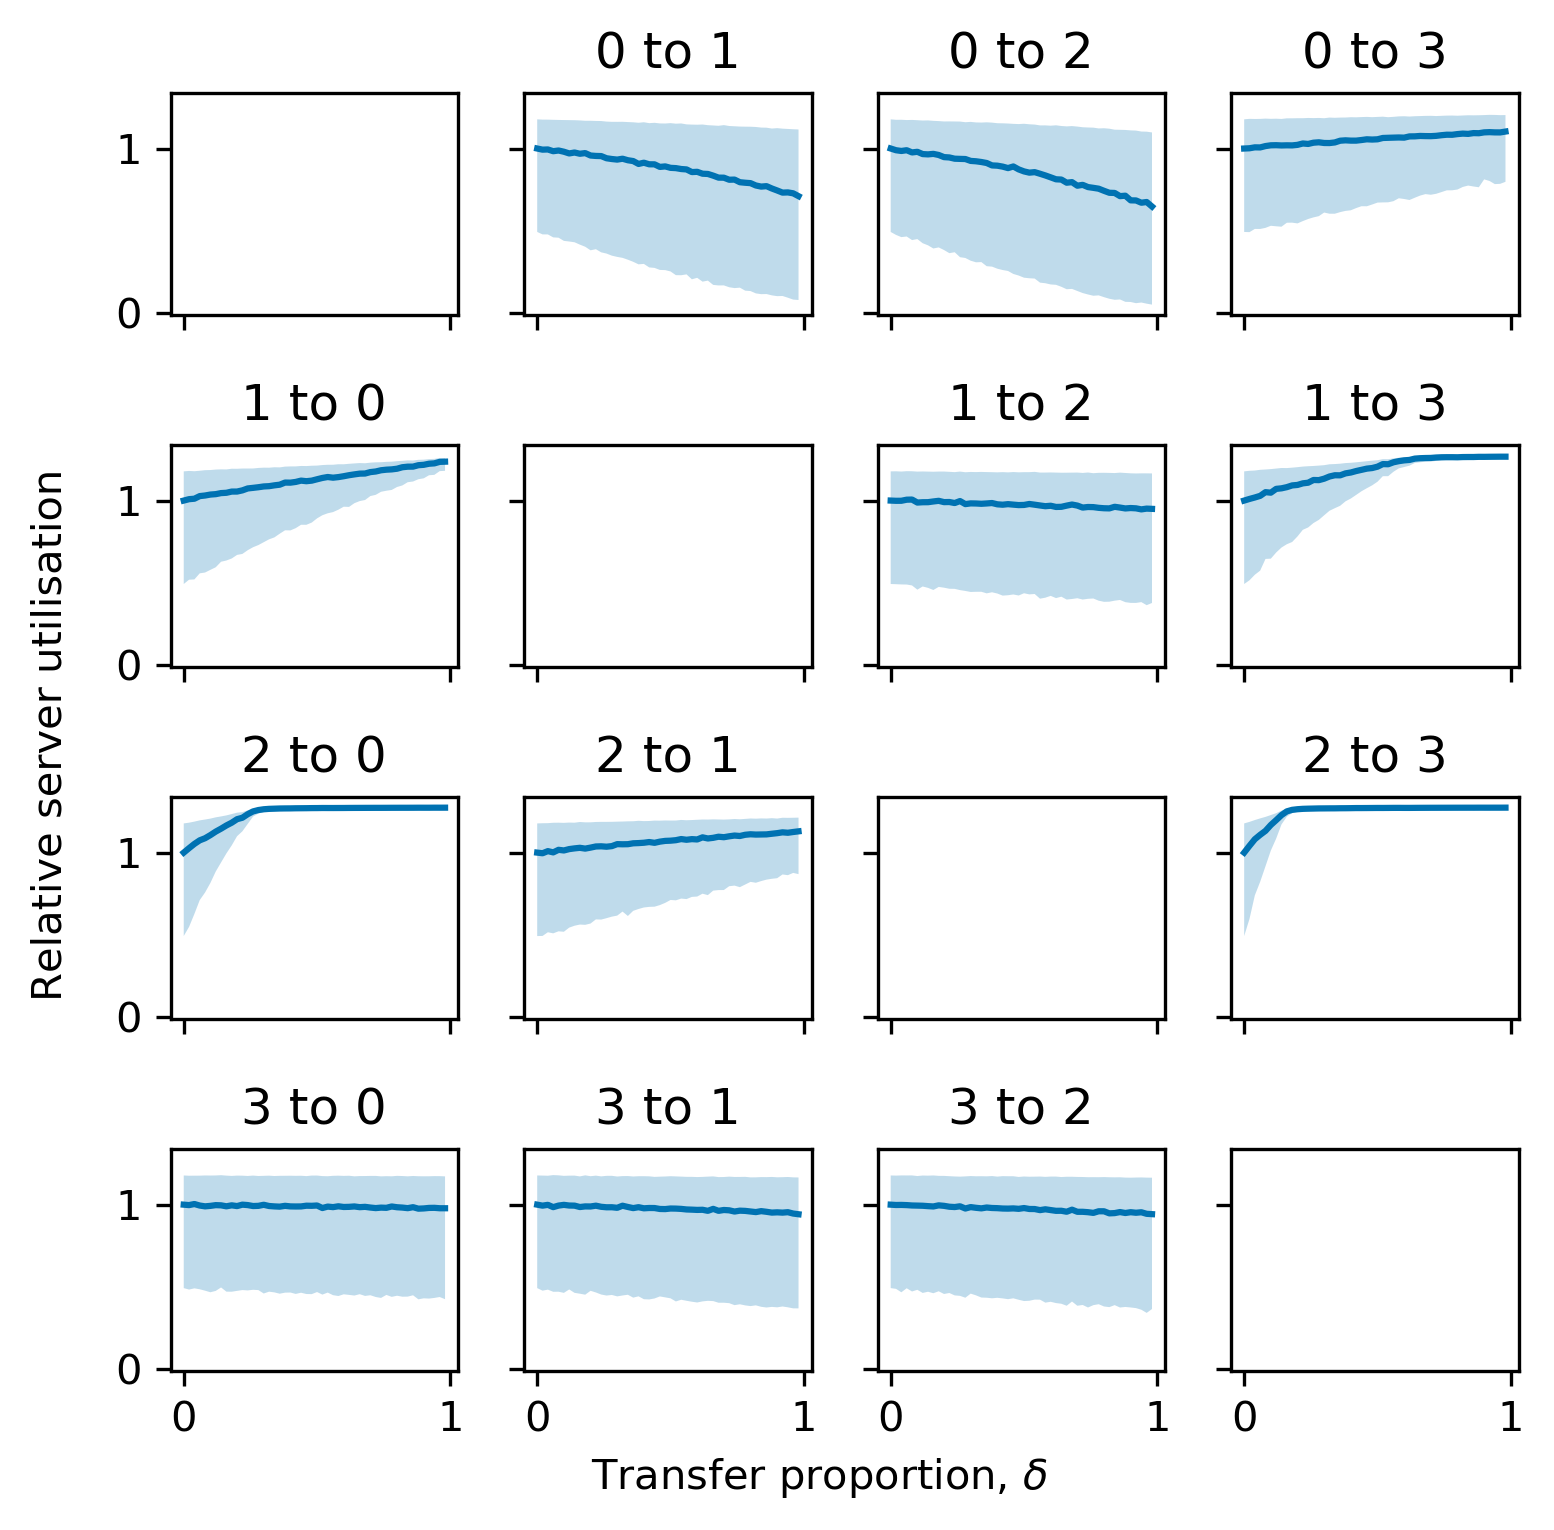

In [17]:
make_split_plot(
    data=moving_utilisations,
    column="utilisation",
    ylabel_text="Relative server utilisation",
    path="../img/moving_util.pdf",
)

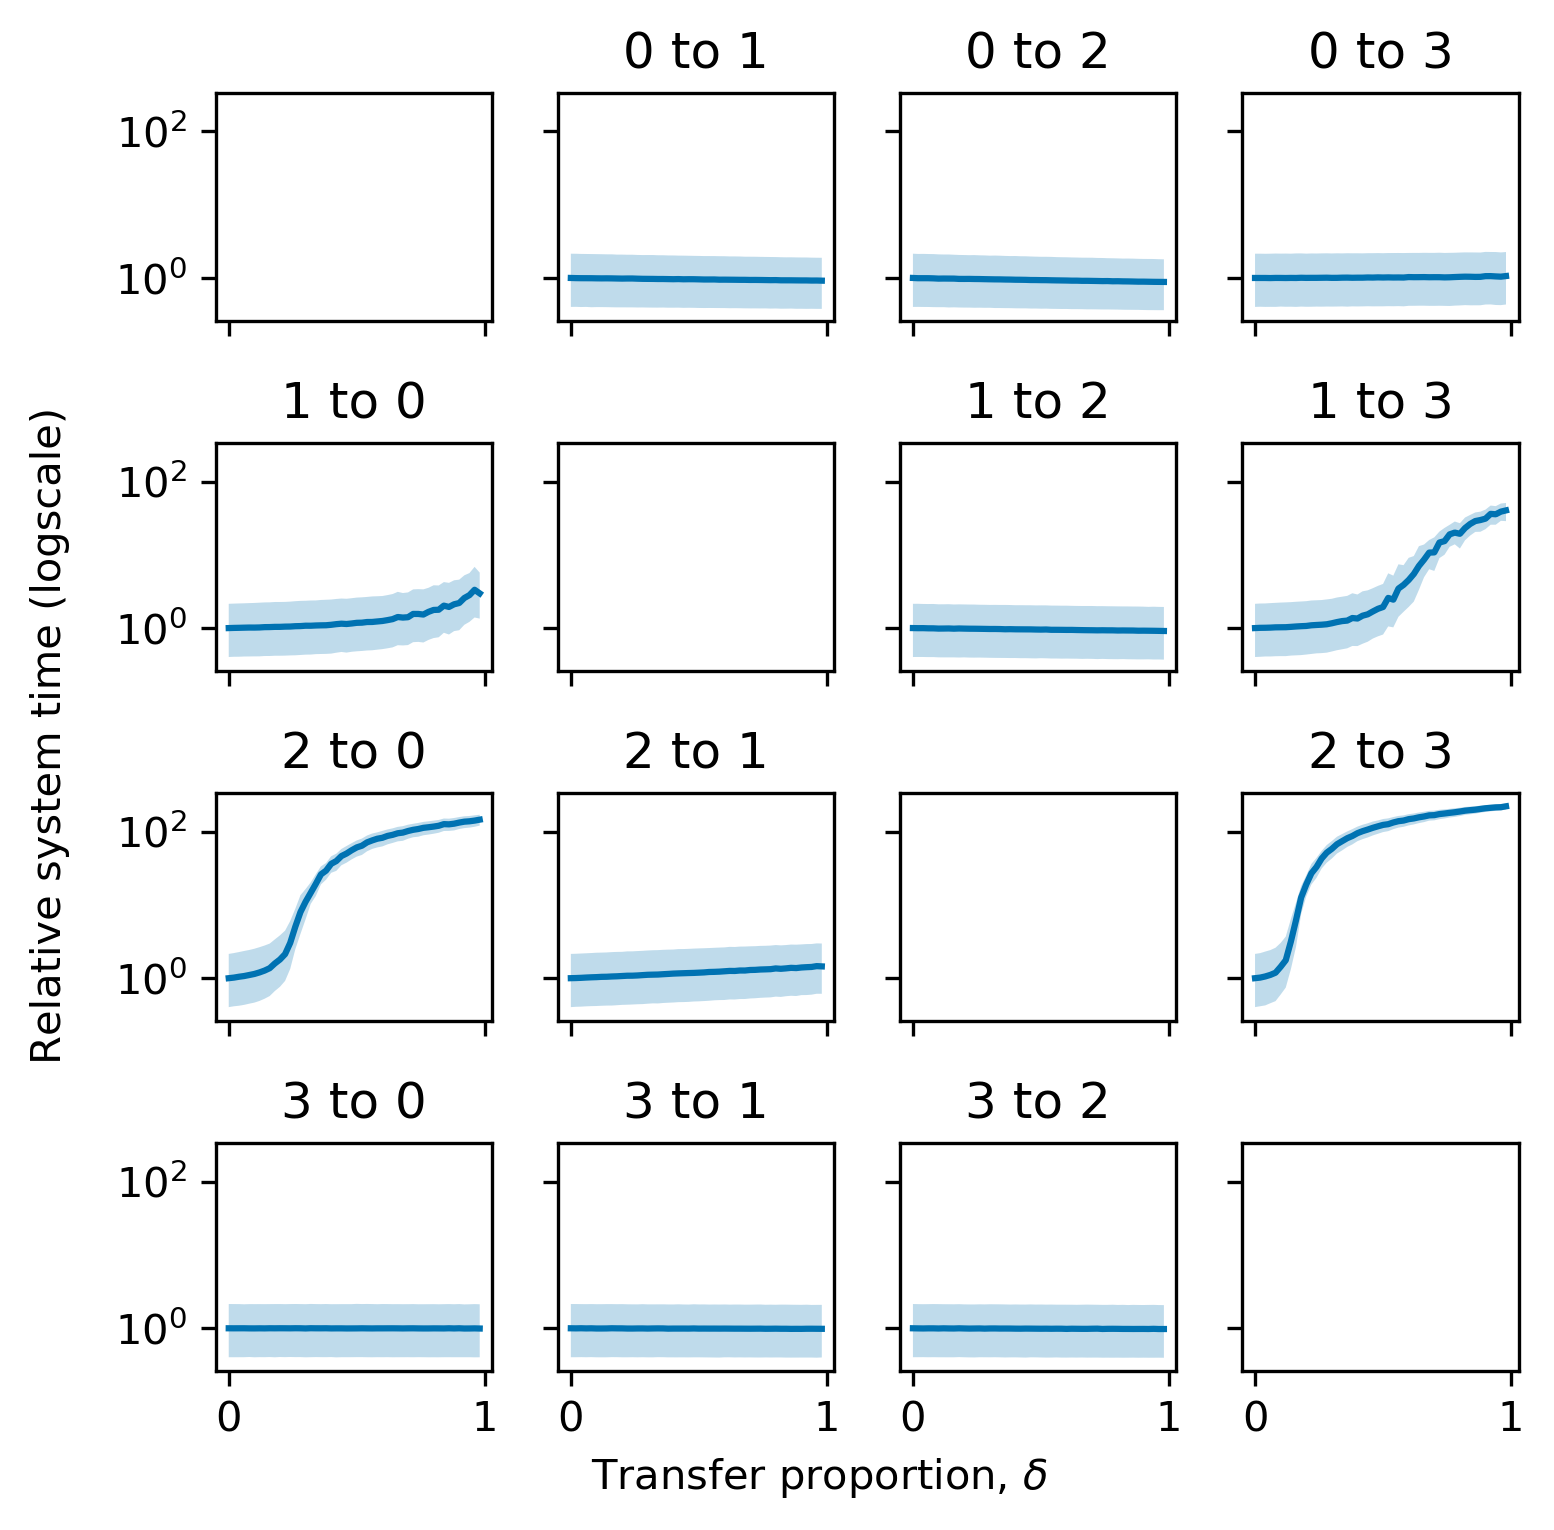

In [18]:
make_split_plot(
    data=moving_system_times,
    column="system_time",
    ylabel_text="Relative system time (logscale)",
    path="../img/moving_time.pdf",
    yscale="log",
    yticks=[1, 100],
)